::: {.callout-note title="Paper in Progress"}
This is a research paper in progress: it's unfinished, messy, and maybe nonsensical, but feedback is always very welcome.

This paper is now [available as a pre-print](https://www.crimrxiv.com/pub/ngqxdnav).

:::

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot_coefficients_vertical_legend(group_name, group_df, color_map):
    if group_df.empty:
        print(f"No data available for group {group_name}. Skipping plot.")
        return None

    factors = group_df['new_name'].dropna().unique()
    x_positions = np.arange(len(factors))
    models = group_df['model'].unique()
    bar_width = 0.8 / len(models)

    fig = plt.figure(figsize=(12, 6))
    for i, model in enumerate(models):
        model_data = group_df[group_df['model'] == model]
        aligned_data = model_data.set_index('new_name').reindex(factors).reset_index()
        positions = x_positions + i * bar_width
        coeffs = aligned_data['Coef.']
        ci_low = aligned_data['ci_low']
        ci_high = aligned_data['ci_high']

        bar_style = {"color": 'dimgray', "hatch": '//', "alpha": 0.8, "edgecolor": 'black'} if model == "human" else {"color": color_map.get(model, 'blue'), "alpha": 0.8, "edgecolor": 'black'}
        error_color = 'black'

        plt.bar(positions, coeffs, bar_width, label=model, **bar_style)
        plt.errorbar(positions, coeffs, yerr=[coeffs - ci_low, ci_high - coeffs], fmt='none',
                     ecolor=error_color, capsize=3, alpha=0.8)

    plt.xticks(x_positions + bar_width * (len(models) - 1) / 2, factors, rotation=45, ha='right')
    plt.ylabel('Regression Coefficients')
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    plt.legend(title="Model", loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1)
    plt.tight_layout()
    
    return fig

def main(coefficients_path, new_names_path):
    coefficients = pd.read_csv(coefficients_path)
    new_names = pd.read_csv(new_names_path)
    coefficients = coefficients.merge(new_names, left_on='Unnamed: 0', right_on='Original_name', how='left')
    coefficients.rename(columns={'[0.025': 'ci_low', '0.975]': 'ci_high'}, inplace=True)
    coefficients['significant'] = coefficients['P>|t|'] < 0.05

    missing_name_mapping = {
        "C(age, Treatment(reference=25))[T.5]": "Age 5",
        "C(age, Treatment(reference=25))[T.10]": "Age 10",
        "C(age, Treatment(reference=25))[T.14]": "Age 14",
        "C(age, Treatment(reference=25))[T.16]": "Age 16",
        "C(age, Treatment(reference=25))[T.20]": "Age 20",
        "C(age, Treatment(reference=25))[T.50]": "Age 50",
        "C(age, Treatment(reference=25))[T.80]": "Age 80",
        "C(hours_missing, Treatment(reference=8))[T.10]": "Hours Missing 10",
        "C(hours_missing, Treatment(reference=8))[T.14]": "Hours Missing 14",
        "C(hours_missing, Treatment(reference=8))[T.18]": "Hours Missing 18",
        "C(ethnicity, Treatment(reference='White'))[T.Asian]": "Ethnicity: Asian",
        "C(ethnicity, Treatment(reference='White'))[T.Black]": "Ethnicity: Black",
        "C(ethnicity, Treatment(reference='White'))[T.mixed race]": "Ethnicity: Mixed Race"
    }
    coefficients['new_name'] = coefficients['new_name'].fillna(
        coefficients['Original_name'].map(missing_name_mapping)
    )

    grouped_coefficients = coefficients.groupby('Group')
    unique_models = coefficients['model'].unique()
    color_map = {model: plt.cm.tab10(i % 10) for i, model in enumerate(unique_models)}

    plots_dict = {}
    for group_name, group_df in grouped_coefficients:
        plot = plot_coefficients_vertical_legend(group_name, group_df, color_map)
        if plot:
            plots_dict[group_name] = plot
            plt.close(plot)  # Close the figure to free memory
    
    return plots_dict


coefficients_path = "data/copbot_coefficients.csv"  # Replace with your file path
new_names_path = "data/copbot_new_names.csv"    

coefficient_plots = main(coefficients_path, new_names_path)


# Abstract

The increasing adoption of Large Language Models (LLMs) in various domains raises questions about their application in policing and criminal justice, particularly regarding their ability to accurately assess risk and threat. This study examines how LLMs perceive and evaluate risk in missing person cases compared to human decision-makers. Using a purpose-built website, we collected over 600 risk assessments from human participants and compared these with assessments from seven different LLM models on randomly generated missing person scenarios. Through regression analysis, we found that while high-performing models like GPT-4o and Llama-3.1-70b generally aligned with human risk perceptions, showing mean absolute errors below 0.6 on a 4-point scale, they exhibited concerning biases, particularly regarding race. Unlike human assessors who showed no significant racial bias, all models demonstrated some form of racial bias in their risk assessments. Models also varied significantly in their evaluation of other risk factors, such as time missing and criminal history. Our findings suggest that while LLMs show promise for risk assessment applications, their deployment in policing contexts requires careful auditing for consistency and bias, particularly when dealing with protected characteristics.

# Introduction

Since the public release of ChatGPT in 2022, there has been an explosion of interest in the application of Large Language Models (LLMsa) to a range of fields, including crime and policing. There is growing evidence that in some contexts, generative language models can aid human decision makers to make faster, more accurate decision, with one notable study examining the productivity of call centre handlers finding real productivity gains across their workforce (@brynjolfssonGenerativeAIWork2023). In the face of growing demand, reduced budgets, and pressure from central government, UK policing has started trying to seize these opportunities... and the market is responding with a number of "of the shelf" products designed specifically for law enforcement.

Perhaps the most recognisable of these tool is DraftOne, which brings together body-worn video footage and the OpenAI GPT-4o model to augment the process of writing statements: where once a police officer would have written a long, detailed statement from video records or from memory, now a generative AI model will create a "skeleton" report, containing the critical facts from the video, and leave the officer to "complete the blanks" and finalise the report. Axon claims officers "spend spend up to 40% of their  time writing" reports, and that DraftOne could "cut that time in half"[^1]. While researchers in the UK couldn't replicate those benefits (@adamsNoMansHand2024), they do find a range of other improvements, including completeness and cohesiveness. And while DraftOne may have been one of the earliest tools to involve generative AI in police decision making, it certainly won't be the last, with other suppliers already touting it's potentially transformative benefits[^2] that go far beyond report writing: generative AI could help automate a vast range of tasks in the criminal justice system, from helping identify critical evidence, to translating witness testimony, or even providing audio-visual description of trials.

[^1]: https://www.axon.com/products/draft-one
[^2]: https://policinginsight.com/feature/advertisement/fighting-the-bad-and-finding-the-good-in-generative-ai/



but how does changing one word matter? Surely it's factual, and if a huamn is oin hte loop, then the decision can't really change... can it?

Indeed, there is growing evidence that LLM enabled tools can, in the right context, provide real productivity benefits - roduce meaningful productivity benefits in certain contexts, though the evidence in policing remains poor. 

There are however, specific challenges within these domains. Language Models reflect the text they are trained on, and as such, are subject to bias - while the concerns around algorithmic bias in policing are already broadly recognised, broad application of language models could aggravate these concerns, in ways that may be opaque or undetected. 

In addition, policing and crime often deal with accurate individual perceptions of threat and risk: for example, a witness statement may ask the individual to recall how they felt at a specific time, and the perceived lack of safety may impact the existence of a crime, or the severity of sentencing. There is little to no research as to how accurately language models reflect human perceptions of threat and risk, or how this may interact with inbuilt biases around, for example, ethnicity or age.

To examine the presence of bias in individuals, one approach that has become frequently used in policing is **vignette studies**: asking individuals to consider simulated scenarios, and assess what an appropriate outcome may be (for example, whether an arrest or search would be justified.) In this paper, we apply a similar approach to language models, to answer our research question.

For ease of analysis and to ensure our findings are broadly applicable, we focus on the perception of risk around missing people reported to police in the England & Wales. How these case are responded to and assessed is heavily regulated according to the College of Policing Approved Professional Practice, and as such is subject a well understood risk assessment: when a missing person is first reported, the reporting officer will conduct an initial assessment of risk, from "high risk" (where the risk of serious harm is very likely) to "very low risk", where there is a very low risk of harm to either the subject or the public.

Using an online website designed for this research, we collected over 600 ratings from individuals, and then compared this to ratings from language models. By varying the circumstances of the missing person, this has allowed us to examine and measure perceptions of threat, risk, and bias in a range of language models. 

# Literature Review

While there is limited evidence around the productivity benefits of LLMs in policing, we know they can be effective tools to improve productivity in some contexts: @brynjolfssonGenerativeAIWork2023 found that for customer service agents, access to an LLM enabled tool "increases productivity, as measured by issues resolved per hour, by 14% on average, including a 34% improvement for novice and low-skilled workers but with minimal impact on experienced and highly skilled workers."

The research that does exist suggests these may not translate to policing: @adamsNoMansHand2024 conducted a robust, pre-registered randomised control trial for the DraftOne tool, and find that officers using the tool are no faster than those without it (though they do see improvements in report quality, for instance improved spelling and coherence). It suggests that the lack of productivity benefits may be down to existing use of template documents. As this only covers a single tool in a single operational context, further research is likely required to understand the mechanism. 

Beyond productivity benefits, some researchers have examined how LLMs be specifically risk in the domains of crime and justice. @fergusonGenerativeSuspicionRisks2024 examines this from a legal perspective, noting that generative AI might "infect a foundational building block of the criminal justice system." @chanConversationalAIPowered2024 examine these concerns empirically in relation to witness statements, and find that LLM chatbots can unexpectedly create "false memories", encouraging witnesses to recall events that have not truly occured. Similarly, @hobsonArtificialFairnessTrust2023 examined whether algorithmic decisions might be perceived as less "just" than human decisions, and does find this to be the case.

# Data and Method
To collect our data, a public website was set up at [https://copbot.online/](https://copbot.online/), which was shared amongst a range of online police communities (eg, police reddit, twitter, and others). The website provides information about assessing risk from the College of Policing APP, collects a small number of personal details (such as their rough location, and whether or not they are a police officer or staff), and then walks them through conducting a risk assessment on a missing person scenario. 

The scenario is randomly generated for each visitor, by varying a small number of key variables for the missing person:

- Their sex (male or female)
- Their age (5,10,14,16,20,25,50,80) 
- What time they are reported missing / how long they have been missing ('eight PM', 'ten PM', 'two AM', '6 AM')
- Ethnicity ('White', 'mixed race', 'Asian', 'Black')
- Whether the episode is out of character, whether they are a regular missing person, or if they are involved in crime ("they are known to have been involved in crime, and their disappearance is not out of character", "they are being reported by family members, who are concerned as this has never happened before", "The informant is not worried, as he says this has happened before and they always come home safe.")

The variables are then combined into a generate scenario, as in the example below:
 
**It is eight PM, and you are receiving a report of a missing person. They are a 50 year old, Asian male, who has gone missing from their home in London. They were last seen around midday. The informant is not worried, as he says this has happened before and they always come home safe.**

The individual is then asked to complete a risk assessment, according to the College of Policing principles, scoring the case on a sliding scale between "very low risk" and "high risk". For measurement purposes, this scale is scored between 0 and 4, with 0.1 intervals.

The same scenario is then put to 2 distinct LLM models, each of which is asked to submit results on 20 occasions (to allow us to study variance in their decision making). Each response is then stored for further analysis, along with the original scenario.

Once the website had been created, we circulated the address through a range of policing online communities and social media, including Reddit and Twitter - as such, this is largely convenience sampling. Between July 2024 and December 2024, we collected around 610 results.

## Models
For ease of analysis, we used [LiteLLM](https://www.litellm.ai/) to query a range of different LLM models using the same approach.  we focus on models from OpenAI, as well as a range of "open source" or other permission models, provided via [Groq](https://groq.com/), an online platform for serving language models.

To ensure the models returned measurable responses, we used "Structured Output" (we force the model to return entries in a numberical format). Not every model is compatible with this approach, and as such we only use a small number of models (this also allows us to reduce our costs).

- OpenAI Models
    - GPT-3.5
        - Summary: Released in March 2022, GPT-3.5 is a large language model with 175 billion parameters, and was a basis for ChatGPT, known for its improved ability to follow instructions compared to previous versions.
    - GPT-4o
        - Summary: Released in May 2024, GPT-4o is one of OpenAI's current flagship models, featuring improved performance in text, vision, and audio tasks compared to its predecessors. Its parameter count is not publicly disclosed.
    - GPT-4o-Mini
        - Summary:  Released in May 2024, GPT-4o-Mini is a smaller, faster variant of GPT-4o intended for testing purposes, and its performance is anticipated to be closer to that of GPT-4, but its parameter count is not publicly disclosed.
- Groq Models
    - Gemma2-9b-it
        - Summary: Gemma2-9b-it is a 9 billion parameter, open-access language model from Google, scheduled for release in June 2024. It is the second generation of the Gemma models.
    - Llama-3.1-70b-versatile
        - Summary: Released in April 2024, Llama-3.1-70b-versatile is a 70 billion parameter, open-source language model from Meta, notable for its performance on various benchmarks, including reasoning and coding tasks.
    - Llama-3.1-8b-versatile
        - Summary: Released in April 2024, Llama-3.1-8b-versatile is an 8 billion parameter, open-source language model from Meta, designed to be more accessible for developers with limited computational resources.
    - Mixtral-8x7b
        - Summary: Released in December 2023, Mixtral-8x7b is a 46.7 billion parameter, open-source language model from Mistral AI, utilizing a sparse mixture-of-experts architecture.

## Analytical Approach

For our analysis, we build a series of linear regression models, that attempt to forecast the predicted risk of any one entry based on other factors. While this approach isn't perfect, it gives us a quick and replicable way of building a statistical model for how each language model makes decisions, and attempting to isolate the effect (if any) of any one factor.

We treat every variable as either categorical with a dummy variable or a boolean (for example, our sex variable with be 1 for female, and 0 for male). Again, while this approach is not perfect, it allows us rapid and interpretable analytical approach.

$$
\begin{align}
\text{RiskAssessment} = \beta_0 &+ \beta_1\text{LocationUS} + \beta_2\text{LocationInternational} \\
&+ \beta_3\text{RiskFactor}_\text{out of character} \\
&+ \beta_4\text{Gender}_\text{male} \\
&+ \beta_5\text{AgeGroup}_\text{>25} \\
&+ \beta_6\text{TimeMissing}_\text{>8hrs} \\
&+ \beta_7\text{Ethnicity}_\text{white} + \epsilon
\end{align}
$$

We also build an additional bespoke model for human decision makers, to allow us to consider additional variables (whether they are police affiliated, and their location).

$$
\begin{align}
\text{RiskAssessment} = \beta_0 &+ \beta_1\text{IsPoliceOfficer} + \beta_2\text{PoliceFamily} + \beta_3\text{MemberOfPublic} \\
&+ \beta_4\text{LocationUS} + \beta_5\text{LocationInternational} \\
&+ \beta_6\text{RiskFactor}_\text{out of character} \\
&+ \beta_7\text{Gender}_\text{male} \\
&+ \beta_8\text{AgeGroup}_\text{>25} \\
&+ \beta_9\text{TimeMissing}_\text{>8hrs} \\
&+ \beta_{10}\text{Ethnicity}_\text{white} + \epsilon
\end{align}
$$

Using these models, we can then examine the coefficients for individual factors to understand their strength, and statistical significance to understand if they have a broadly meaningful impact. 

# Results
## Model performance

To obtain a high level view of how the model perceptions of risk compare to human submitted scores, we calculate a few metrics on a model by model basis, treating the human risk submission as "correct" for the given scenario. For each model, we compute the mean error, mean absolute error, variance of error, and root mean square error (RMSE).



In [3]:
#| label: tbl-model-performance
#| tbl-cap: Model error metrics (as compared to human risk scores)

import pandas as pd
import numpy as np

# Load the CSV file
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

# Process the data to calculate metrics
def calculate_metrics(data):
    # Filter out human predictions as the baseline
    human_predictions = data[data['model'] == 'human'][['id', 'predicted_risk']]
    human_predictions.rename(columns={'predicted_risk': 'human_risk'}, inplace=True)

    # Merge human predictions into the main dataset
    merged_data = data.merge(human_predictions, on='id', how='left')

    # Calculate errors
    merged_data['error'] = merged_data['predicted_risk'] - merged_data['human_risk']
    merged_data['absolute_error'] = merged_data['error'].abs()

    # Group by model to calculate metrics
    model_metrics = merged_data.groupby('model').agg({
        'error': ['mean', 'var'],
        'absolute_error': 'mean',
        'predicted_risk': lambda x: np.sqrt(np.mean((x - merged_data.loc[x.index, 'human_risk']) ** 2))
    }).reset_index()

    # Rename columns for clarity
    model_metrics.columns = ['model', 'mean_error', 'variance_error', 'mean_absolute_error', 'rmse']
    return model_metrics

# Main function to process the file and return a dataframe
def main(file_path):
    data = load_data(file_path)

    # Rename specific models
    data['model'] = data['model'].replace({
        'groq/mixtral-8x7b-32768': 'mixtral-8x7b',
        'groq/llama-3.1-8b-instant': 'llama-3.1-8b'
    })

    # Calculate and return metrics as a dataframe
    return calculate_metrics(data)

file_path = 'data/results.csv'
metrics_df = main(file_path)
metrics_df['model'] = metrics_df['model'].str.replace('groq/', '')
metrics_df.columns = ['model', 'Mean Error', 'Variance of Error', 'Mean Absolute Error', 'RMSE']
metrics_df.drop(5).set_index('model').sort_values('RMSE').round(3)


,Mean Error,Variance of Error,Mean Absolute Error,RMSE
model,,,,
llama-3.1-70b-versatile,-0.030,0.503,0.561,0.710
gpt-4o-mini,-0.027,0.572,0.567,0.756
gpt-4o,0.346,0.546,0.588,0.816
llama-3.1-8b,-0.245,0.793,0.732,0.924
gemma2-9b-it,-0.423,0.742,0.780,0.960
gpt-3.5-turbo,0.007,0.966,0.812,0.983
mixtral-8x7b,-0.698,0.725,0.878,1.101


Model by model scores are listed in @tbl-model-performance, and are ranked by RMSE, which suggests that the model least that is most closely aligned to human performance is Llama-3.1-70b, with a mean error of 0.561. Conversely, the model least aligned is mixtral, with a mean error of 0.878 (nearly double that of Llama 3.1).

While it is challenging to interpret these results, two conclusions stand out. First, this is quite a large variance in "performance": the mean absolute error for mixtral is more than 50% larger than that of Llama 70b, despite the fact they are models of broadly similar sizes (though with very different architectures.)

Secondly, we also see variance in the *direction* of the mean error by model: while gpt-4o performs well on average, it seems to regularly over-estimate risk compared to human evaluators, with a mean error of 0.346, while mixtral seems to under under-estimate it instead, with a mean error of -0.698. Notably, while gpt-3.5 performs relatively poorly (with an RMSE of 0.983), it's mean error is close to 0, suggesting it's risk scores reflect human decision makers on average, but suffer from high variance - this is also reflected in the high variance of error.

To explore this variance futher, we provide, for each model, their current score on [Chatbot Arena](https://lmarena.ai/), an "open-source platform for evaluating AI through human preference, developed by researchers at UC Berkeley SkyLab and LMSYS" [see @chiangChatbotArenaOpen2024] - these provide a broad metric of how "good" human scorers consider the model to be on general tasks.

We also compare this with the r-squared value of the model by model regression, which will also reflect the consistency of decision making, with models with the highests r-squared exhibiting predictable and consistent decisions.
These scores are listed in @tbl-arena-scores.

| Model                  | R2 (of model regression) | RMSE (compared to human) | Arena Score |
|------------------------|--------------------------|--------------------------|-------------|
| llama-3.1-70b-versatile| 0.634                   | 0.710                    | 1248        |
| gpt-4o-mini             | 0.825                   | 0.756                    | 1273        |
| gpt-4o                 | 0.796                   | 0.816                    | 1317        |
| llama-3.1-8b-instant   | 0.303                   | 0.924                    | 1176        |
| gemma2-9b-it           | 0.276                   | 0.960                    | 1191        |
| gpt-3.5-turbo          | 0.662                   | 0.983                    | 1117        |
| mixtral-8x7b-32768     | 0.786                   | 1.101                    | 1114        |

: Model variance, RMSE and Arena score {#tbl-arena-scores}

For ease of interpretation, we also visualise these scores in a scatter plot @fig-model-comparison-arena.

On the X axis, we display our regression R-squared value (with models furthest to the right being most consistent), while the Y axis shows our RMSE value (with models nearest to 0 being the closest to human decision makers). Finally, the size of the "bubble" reflects the model score on LM Arena, with larger bubbles indicating answers most preferred by human scorers. 

We should expect our "best" models to be at the bottom right of the chart, with a large bubble, indicating highly consistent decisions, that reflect human scores, and are scored highly by humans on general tasks.

Looking at the plot, while we do the models we expect to perform well in that corner (llama-70b, gpt-4o, and 4o-mini are all grouped in this region), where the rest of the models are placed is notable.

Our two smallest models (gemma-9b and llama-8b) are clustered together, indicating similar variance and error, but also have comparatively high LM Arena scores, **indicating that while they might generate satisfying answers to common tasks, they are comparatively poor in the domain of assessing risk.**

Our "mid-range" models (gpt-3.5 and mixtral) fall broadly in between, but notably there is a fair bit of difference between the scores and consistency of both models (which will continued to be notable as we dig into model by model differences).

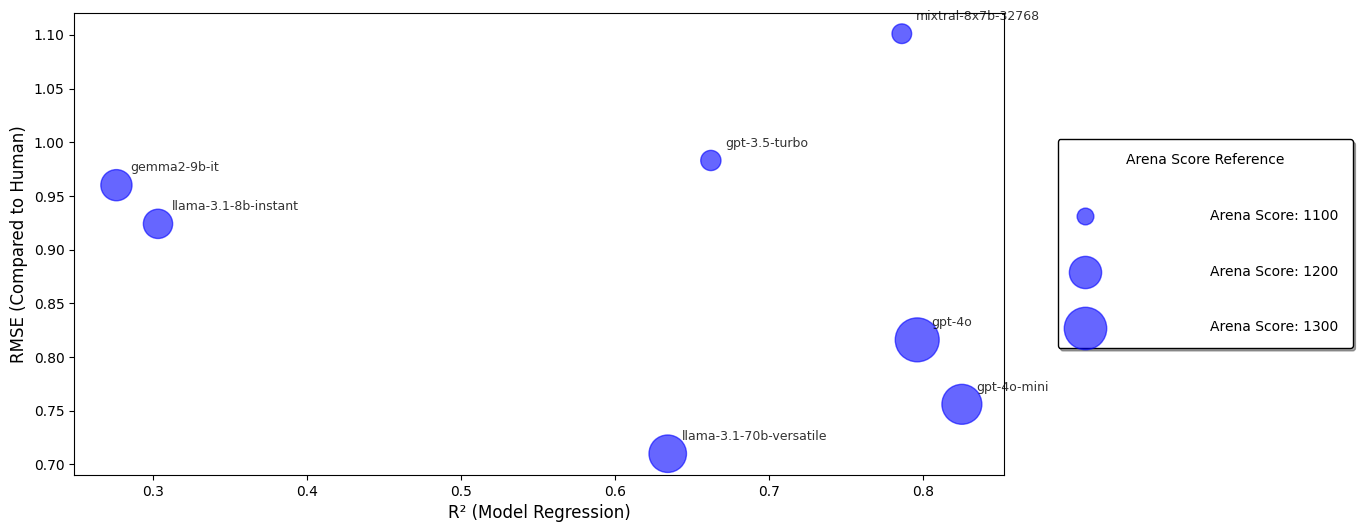

In [4]:
#| label: fig-model-comparison-arena
#| fig-cap: Scatter plot of model error against humans (RMSE), variance (R2) and arena score
#| column: page-inset

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read and prepare the data
data = pd.read_csv('data/model_variance.csv')

# Calculate normalized sizes
score_min = data['Arena Score'].min()
score_max = data['Arena Score'].max()
normalized_sizes = ((data['Arena Score'] - score_min) / (score_max - score_min) * 800) + 200

# Create the plot with extra width to accommodate legend
plt.figure(figsize=(12, 6))  # Increased width from 12 to 14

# Create scatter plot
scatter = plt.scatter(data['R2 (of model regression)'], 
                     data['RMSE (compared to human)'],
                     s=normalized_sizes,
                     alpha=0.6,
                     color='blue',
                     marker='o')

# Add annotations for each point with adjusted offset
for i, model in enumerate(data['Model']):
    plt.annotate(model, 
                (data['R2 (of model regression)'].iloc[i], data['RMSE (compared to human)'].iloc[i]),
                xytext=(10, 10),  # Increased offset
                textcoords='offset points',
                fontsize=9,       # Slightly larger font
                alpha=0.8)

# Add axis labels and title
plt.xlabel('R² (Model Regression)', fontsize=12)
plt.ylabel('RMSE (Compared to Human)', fontsize=12)

# Create legend with actual sizes matching the scatter plot
reference_scores = [1100, 1200, 1300]
reference_sizes = ((np.array(reference_scores) - score_min) / (score_max - score_min) * 800) + 200

legend_elements = []
for score, size in zip(reference_scores, reference_sizes):
    legend_elements.append(
        plt.scatter([], [], 
                   s=size,
                   c='blue',
                   alpha=0.6,
                   marker='o',
                   label=f'Arena Score: {score}')
    )

# Add legend with improved spacing
plt.legend(handles=legend_elements,
          title='Arena Score Reference',
          bbox_to_anchor=(1.05, 0.5),
          loc='center left',
          title_fontsize=10,
          frameon=True,
          edgecolor='black',
          fancybox=True,
          shadow=True,
          labelspacing=3,       # Vertical space between entries
          borderpad=1,          # Padding between legend border and entries
          handletextpad=8       # Space between marker and text
          )

# Show the plot
plt.show()

### Comparing regression models
To compare our models, we will examine the coefficients of each factor (meaning how much, on average, they seem to effect the risk score, attempting to hold other factors constant.) We also generate p-values and error bars at the 95% confidence interval, to examine if the individual factors are significant - p-values are not a perfect tool for this approach, but give us a repeatable rule of thumb we can use for our analysis, allowing us to see if individual factors seem to make a meaningful impact on perceptions of risk. As such, when we refer to significance, this refers to the p<00.5 level, but this should be cautiously interpreted.

#### Human specific factors

We begin by examining human scorers in isolation in @tbl-human-regression, to look at 2 factors which do not apply to our language models:

| Variable | coef | std err | t | P>\|t\| | [0.025 | 0.975] |
|----------|------|---------|---|---------|--------|---------|
| Intercept | 1.5388 | 0.216 | 7.139 | 0.000 | 1.115 | 1.962 ||
| is_police_officer | -0.1656 | 0.189 | -0.876 | 0.382 | -0.537 | 0.206 |
| is_police_family | -0.2228 | 0.195 | -1.142 | 0.254 | -0.606 | 0.161 |
| is_public | -0.3689 | 0.195 | -1.896 | 0.058 | -0.751 | 0.013 |
| us_based | 0.6840 | 0.309 | 2.211 | 0.027 | 0.076 | 1.292 |
| based_elsewhere | 0.4883 | 0.230 | 2.119 | 0.035 | 0.036 | 0.941 |

: Regression coefficients for human decision model {#tbl-human-regression}

Each scorer was asked whether they were a police officer, part of the wider policing family, such as retired officers or police staff, or a member of the public (these were each binary variables, so in theory respondents could select all 3). While none are statistically significant, there is a broad trend downwards, with officers likely to perceive high risk than members of the police family, who in turn seem to perceive it higher than the general public.

On location, we do seem to have significant results (though our number of returns is relatively small), which suggest that UK based respondents (the reference category) consistently perceived a lower risk (around 0.5-0.7) than those outside the UK (though there is likely to be heavy overlap between this and the previous category).

## Individual factor comparisons

### Age  

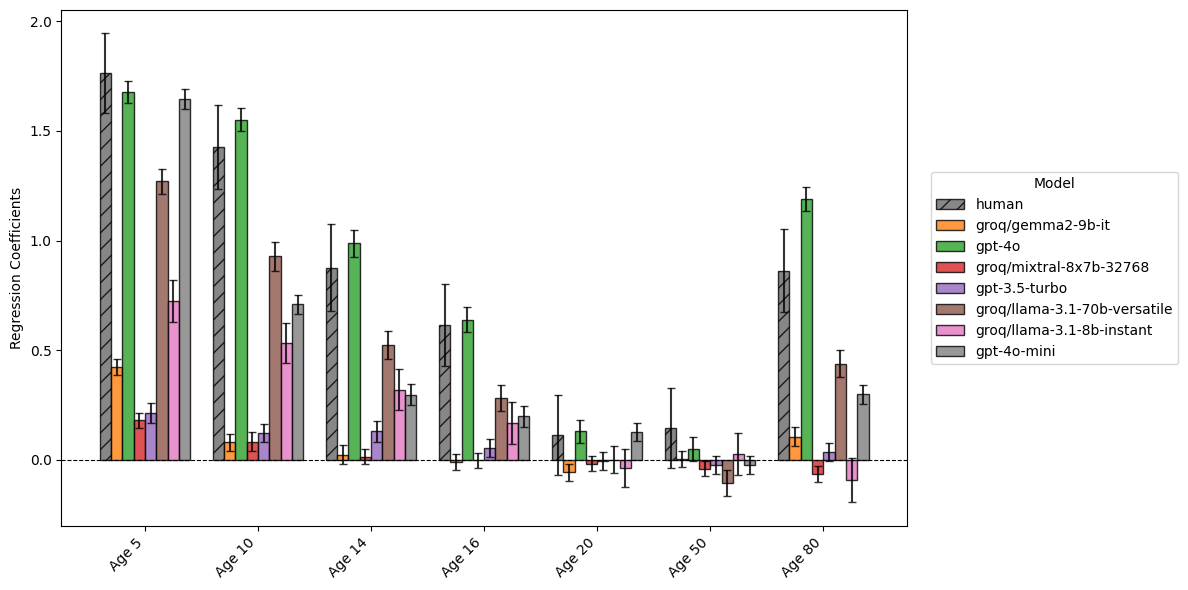

In [5]:
#| label: fig-coefficients-age
#| fig-cap: Regression coefficients by age (25 as reference category)
#| column: page-inset

coefficient_plots['Age (25 as reference category)']

@fig-coefficients-age suggests suggests strong age-related patterns in both human and model assessments. Humans show dramatically higher risk assessments for very young ages (5-14) compared to the reference age of 25, with coefficients declining steadily with age, before increasing for our eldest category (with 80 year olds being assessed somewhere between 10 and 14 year olds in terms of risk).

The best models, such as GPT4o, closely mirror this pattern, though notably GPT4o consistently has even higher coefficients. Other models show more varied responses, with Llama models and Gemma showing generally lower coefficients than humans, particularly for young ages. Notably, many models show no increase in risk from 50 to 80 years old, and mixtral actually displays a small (but significant) decrease.

### Sex

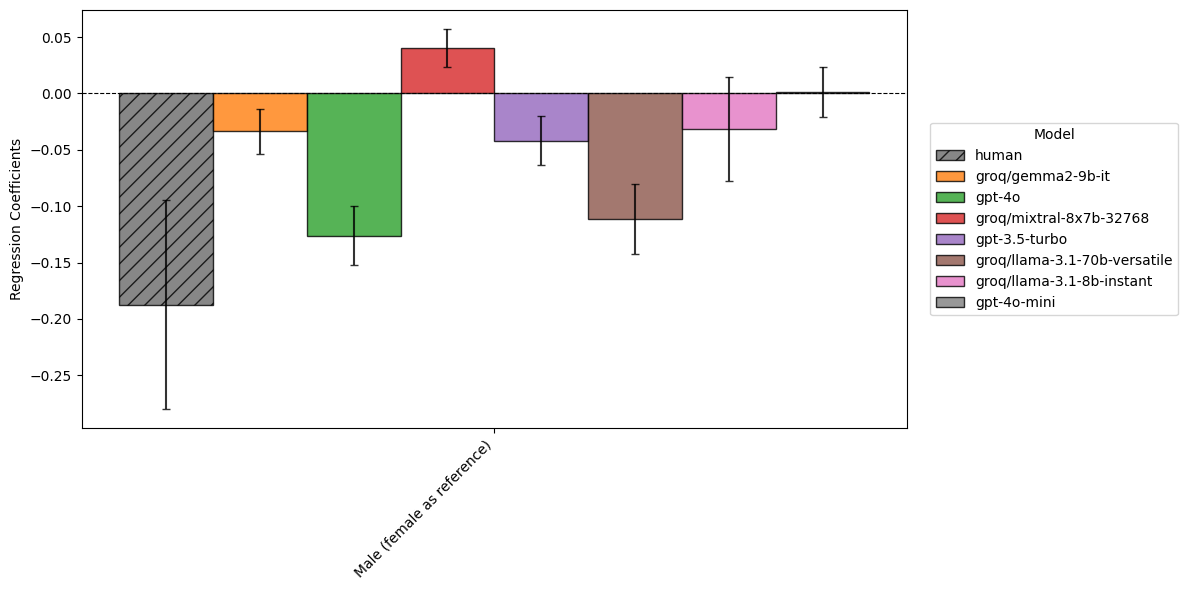

In [6]:
#| label: fig-coefficients-sex
#| fig-cap: Regression coefficients by sex (female as reference category)
#| column: page-inset

coefficient_plots['Sex (female as reference category)']

@fig-coefficients-sex suggests shows significant, but relatively small, effects of sex on risk assessment for both humans and models, with humans reducing their risk by about 0.2 for men. Again, we see the highest performing models behaving broadly similarly (with gpt-4o and llama-70b both reducing their risk by around 0.10-0.15), variance amongst smaller models, with mixtral actually seeing a small but significant increase in risk perception for men.

### Time Missing


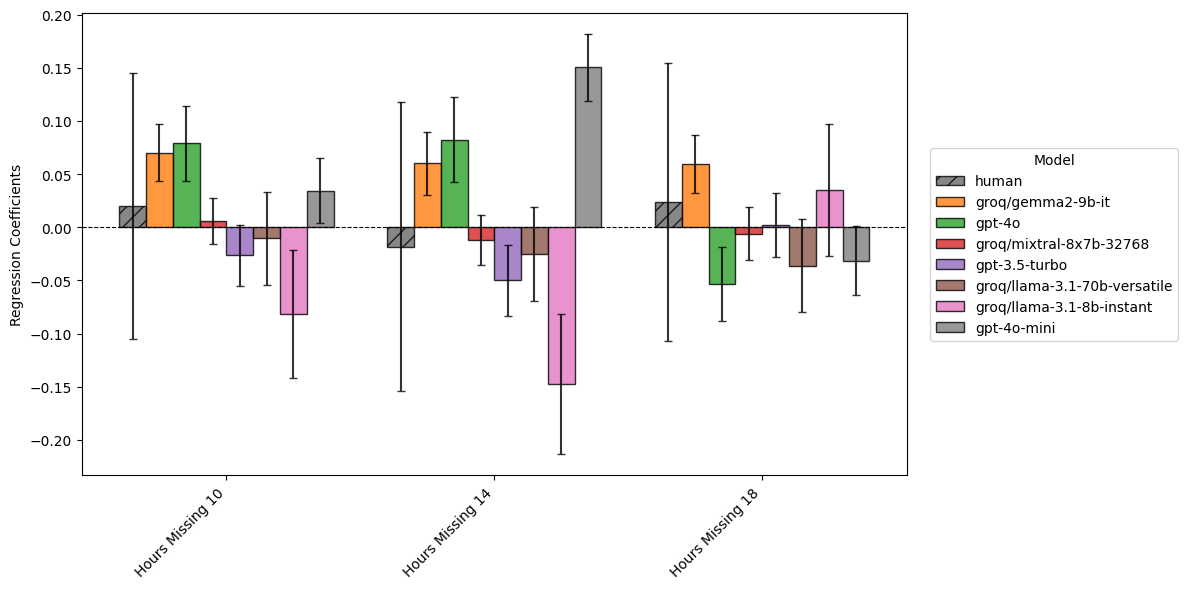

In [7]:
#| label: fig-coefficients-hours-missing
#| fig-cap: Regression coefficients by hours missing (8 as reference category)
#| column: page-inset

coefficient_plots['Hours missing (8 as reference category)']

@fig-coefficients-hours-missing is notable because our human risk scorers did *not* show significant variations in risk assessments based on how long the subject had been reported missing: there is simply too much variance to detect a consistent effect. 

That is *not* the case for our models: gpt-4o and gpt-4o-mini both show increases at the ten and 14 hour marks, while interestingly, llama3.1-8b seems to exhibit a notable decrease.

**Notably, nearly all these effects become significantly weaker, or disappear entirely, at the 18 hour mark.** The varying factor in the text of this vignette is the time at which they are being reported missing - at the 18 hour mark, the report is being made at 6AM, and the subject has been missing since midday the previous day - and this seems to have strong, unexpected effects on model behaviour. 


### Risk Factors


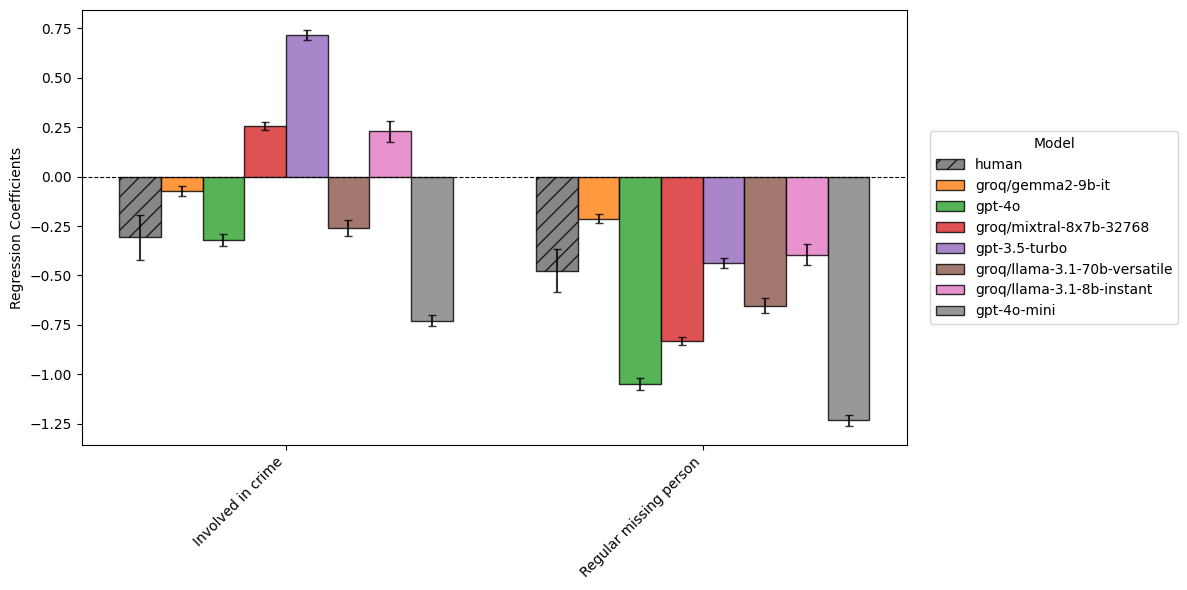

In [8]:
#| label: fig-coefficients-risk-factor
#| fig-cap: Regression coefficients by risk factor (out of character as reference category
#| column: page-inset

coefficient_plots['Risk Factor (out of character as reference category)']

@fig-coefficients-hours-missing shows that for involvement in crime or being a regular missing person (compared to the missing episode being out of character), humans show negative coefficients, suggesting they assess lower risk for these categories.

The regular missing person risk factor shows broad consistency along our models, with risk decreasing across the board. Involvement in crime however, shows more variance: gpt-3.5 shows a strong increase in risk, while gpt-4o-mini shows a strong decrease instead. This is quite striking variance, and may reflect the lengthier scenarios.


### Ethnicity

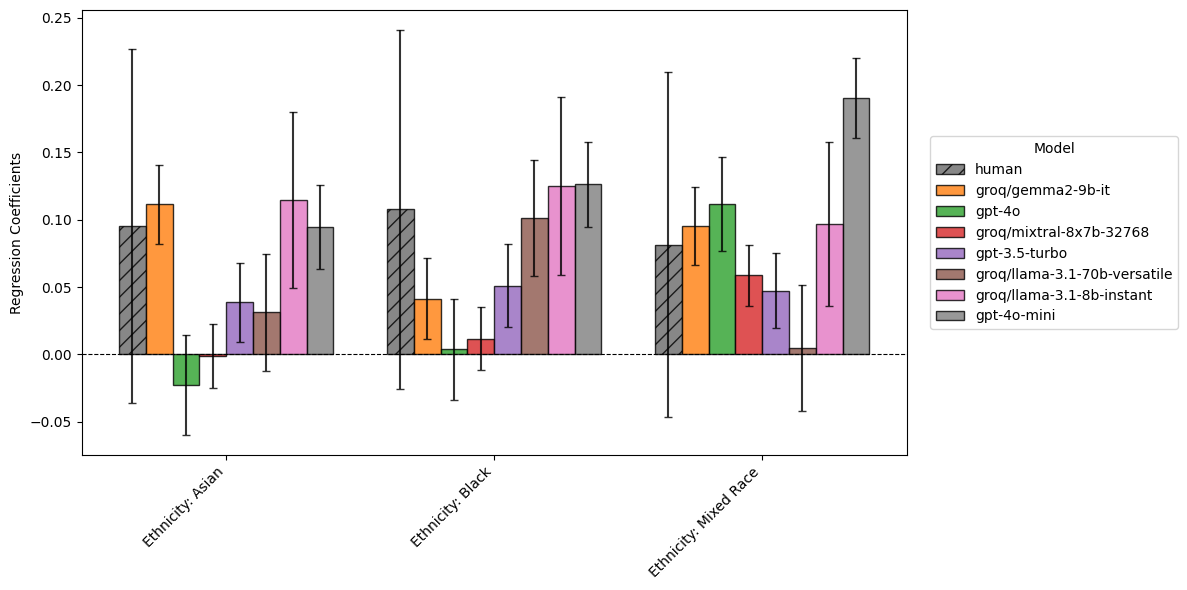

In [9]:
#| label: fig-coefficients-ethnicity
#| fig-cap: Regression coefficients by ethnicity (white as reference category)
#| column: page-inset

coefficient_plots['Ethnicity (white as reference category)']

@fig-coefficients-ethnicity shows that ethnicity made no significant difference to the risk assessment of human assessors - they show no apparent racial bias.

**However, nearly every single model does: while the differences are small, they all appear significant for at least one ethnicity.** Gpt-4o-mini and llama-8b both show increased risk scores of at least 0.1 for subjects that are not white, and most models increase their risk scores for Black and mixed-race subjects.

Notably, gpt-4o and mixtral both show no bias on Asian or Black subjects, but do for mixed-race.

## Discussion

In this analysis, we've compared responses from humans and large language models, using statistical models to measure where they agree, where they disagree, and where they exhibit bias.

At a high level, the results are promising: the most highly performing, "flagship" models, seem to perceive risk and threat in the context of missing people in ways that are similar to human scorers. Scored on a scale from 0 to 4 (where 0 is very low risk and 4 is high risk), a mean error of well under 1 suggest they would lead to outcomes broadly similar to humans, if deployed in a policing context.

For certain risk-factors, such as age, these models also vary their perceptions of risk in ways that are broadly reasonable, and similar to human decision makers (for example, perceiving the very young, or very old, as being most at risk.) We also noted that, for at least one risk factor (the number of hours since the suspect had gone missing), some language models identified a clear risk to a subject, where human decision makers did not - this suggests models could be used as safeguards around inaccurate  decision making.

However, we also identify some causes for concern. Performance varied significantly across models, even for models of similar size, and some models that are generally perceived to do well on general tasks, did not perform as well in their perception of policing risk. We also saw broad variance with how models evaluated the importance of risk factors: models that might perform well overall might still display unexpected behaviours in certain contexts.

In some areas, these behaviours highlighted biases that are likely to be problematic for policing - most notably, when looking at race. **While human decision makers exhibited no statistically significant racial bias in their perception of risk, each and every model we evaluated did, for at least one ethnicity category.**

### Lessons for policy and practice

While the findings of this research should be caveated, it does suggest lessons for the application of LLMs in the context of policing, crime and justice, and other domains where perceived risk and threat may be relevant.

Not all models are equal, but most importantly, **models which perform best in generalist contexts might not be best suited to this context.** Smaller models can be especially problematic, and while these might lead to savings through reduced costs, are likely to have significant other downsides due to their variabilities and biases.

When Daniel Kahneman examined variance in decision making in "Thinking, fast and slow" [@kahnemanThinkingFastSlow2013], he recommended  that companies or agencies where decision making consistency might be critical (such as insurance agencies or judges) undertake a "noise audit" to examine existing variance in their processes. Those considering the application of large language models to policing domains should aim to run a "virtual audit" on historical data, examining a range of language models to examine how they perform on the required task. 

This audit should examine not just variance on the given task, but where variance does exist, does it behave in ways we would expect, and how does it compare to existing human processes. For example, our analysis found while some models treated regularly going missing as a factor that decreased risk, other models saw it as an aggravating factor - you should reassure yourself that any language model being considered for deployment into an operational context at least behaves in line with training and procedures you expect human decision makers to follow.

Finally, any audit should pay special care biases around race, as our analysis suggest the majority of models attribute some bias in this domain, which does not reflect human decision making. Given the potentially catastrophic implications of algorithmic bias for embedding structural concerns, not to mention legal implications, special care should be paid to this category, as well as other protected characteristics.
